Background Information

Data Munging and Analyzing Barcelona OSM Data

The XML data for the city boundary of Barcelona was downloaded from OSM to clean and transform into a json encodable structure to allow loading into MongoDB, providing storage and artbitrary querying to enable further data analysis of the Barcelona OSM dataset. I chose the Barcelona dataset because I just recently spent a few weeks there and noticed some pretty cool urban planning features of the city (ie. Avinguda Diagonal) that could be cool to explore further.

Inspired by the "Diagonality" of Barcelona streets and to give the scope of the project a little more focus, I will be attempting to analyze the Barcelona OSM data and see if I can generate a measure for the "degree of diagionality" for Barcelona and possibly compare this measure with other cities. Not knowing ahead of time the difficulty of this, I may eventually have to delete this previous sentence, but I'm interested enough to give it a shot.

<img src="http://static1.squarespace.com/static/52b3aae6e4b00492bb71aa3d/t/54776cbde4b019f8929d0684/1414769949925/?format=1500w">

From [dailyoverview.com](http://www.dailyoverview.com/six/)

Imports and Data prep

In [29]:
%matplotlib inline
import xml.etree.cElementTree as ET
import pprint
import re
import codecs
import json
import math
import numpy as np
import matplotlib.pyplot as plt
import heapq

OSM_FILE = "C:/Users/Cole/Desktop/Udacity/Data Analyst Nano Degree/Project 3/barcelona_spain.osm"  # Replace this with your osm file
SAMPLE_FILE = "C:/Users/Cole/Desktop/Udacity/Data Analyst Nano Degree/Project 3/barcelona_spain_sample.osm"
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag

    Reference:
    http://stackoverflow.com/questions/3095434/inserting-newlines-in-xml-file-generated-via-xml-etree-elementtree-in-python
    """
    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


with open(SAMPLE_FILE, 'wb') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')

    # Write every 100th top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % 100 == 0:
            output.write(ET.tostring(element, encoding='utf-8'))

    output.write('</osm>')


Visual Data Inspection

In [6]:
#This code attempts to pick out unique data structures from the SAMPLE_FILE to give us examples of 
unique_elements = []
for i,element in enumerate(get_element(SAMPLE_FILE)):
    elem_children = [element.tag]
    for child in element.iter():
        elem_children.append(child.tag)
    if elem_children not in unique_elements:
        unique_elements.append(elem_children)
        print ET.tostring(element, encoding='utf-8')
print len(unique_elements)        

<node changeset="25387850" id="13019203" lat="41.3753852" lon="2.1494473" timestamp="2014-09-12T11:14:11Z" uid="605366" user="EliziR" version="12" />
	
<node changeset="1491449" id="13850807" lat="41.466609" lon="1.9177142" timestamp="2009-06-11T21:18:41Z" uid="55987" user="Jaume Figueras" version="4">
		<tag k="created_by" v="JOSM" />
	</node>
	
<node changeset="105840" id="30716682" lat="41.4700652" lon="2.2914734" timestamp="2007-06-21T11:56:38Z" uid="4992" user="johnrobot" version="1">
		<tag k="source" v="PGS" />
		<tag k="created_by" v="almien_coastlines mod" />
	</node>
	
<node changeset="12851108" id="191001636" lat="41.3711809" lon="2.1751081" timestamp="2012-08-25T01:38:19Z" uid="557004" user="JordiSeguraPla" version="6">
		<tag k="ref" v="20" />
		<tag k="name" v="Port-Mercaderies" />
		<tag k="highway" v="motorway_junction" />
	</node>
	
<node changeset="26789355" id="206191957" lat="41.3417343" lon="2.0900056" timestamp="2014-11-14T23:45:58Z" uid="500572" user="yopaseopor"

Reviewing the unique elements above yields a few considerations for potential data issues and facts pertinent to the goal of reporting a "degree of diagionality":  
1. Being a Spanish City, the non-standard characters common in Spanish names might exist that could cause potential problems 
2. The amount of data for a given node or way varies. The minimum required data to enable calculation of a streets angle will need to be defined.
3. Nodes contain the required lat/lon coordinates required for calculating a ways angle  
4. Ways list the nodes that create the path of a street. This path may not be a straight line, which may have an impact on the angle calculation  
5. Not all ways have a street attribute, but still seem valid, such as examples that have a "highway" attribute

Data Shaping  
In order to perform a calculation of "diagonality" of a way, we need at least 2 nodes on the way that have lat/lon data. To ensure the way is a valid road to calculate diagionality on, the way must have one of: a valid steet or highway attribute. We will only keep top level data such as id, lat/lon and created data for nodes. To load this data into MongoDB for storage and querying, we need to shape this data into valid JSON, which the below code does.

In [3]:
#Utility Regular Expressions
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

#Utility data structures for nested dicts/lists
TOP_LEVEL_DATA = ['id','visible']
CREATED = [ "version", "changeset", "timestamp", "user", "uid"]
POS=['lat','lon']

#This function returns a data dictionary by parsing the data from each key of an elements attributes
#listed in the data_list argument
def data_dict(elem_attribs,data_list):
    return {data_elem:elem_attribs[data_elem] for data_elem in data_list if data_elem in elem_attribs.keys()} 

def extract_top_level_data(element): # this function extract top level data from the elements attributes
    node = data_dict(element.attrib,TOP_LEVEL_DATA)
    created_dict = data_dict(element.attrib,CREATED)
    if created_dict:
        node['created'] = created_dict
    node['type'] = element.tag
    return node
    
def shape_element(element):
    node_refs = []
    if element.tag == "node": #Checks if is node and extracts required data
       node = extract_top_level_data(element)
       for child in element.iter():
            pos_list = [float(child.attrib[pos_data]) for pos_data in POS if pos_data in child.attrib.keys()] #extracts lat/lon data in list and converts to float
            if pos_list:
                node['pos'] = pos_list
       return node
    elif element.tag == "way": #Checks if is way and extracts required data
        node = extract_top_level_data(element)
        for child in element.iter():
            if child.tag =='tag':
                m = re.search(problemchars,child.attrib['k']) #searches for problematic characters and returns None if encountered
                if m:
                    return None
                if child.attrib['k'] =="addr:street":#Checks if way has addr:street attribute and assigns the 'street' key the streets name, otherwise 'highway'
                    node['street'] = child.attrib['v']
                elif "highway" in child.attrib.values() and 'street' not in node.keys():
                    node['street'] = child.attrib['k']
            if child.tag == 'nd':
                node_refs.append(child.attrib['ref'])
        if node_refs:
            node["node_refs"] = node_refs
        else:
            return None
        if 'street' in node.keys() and len(node['node_refs'])>=2: #Only return ways that have a addr:street or highway attribute and 2 or more node refs
            return node
        else:
            return None
    else:
        return None

def process_map(file_in, pretty = False):
    # You do not need to change this file
    file_out = "{0}.json".format(file_in)
    data = []
    with codecs.open(file_out, "w") as fo:
        for _, element in ET.iterparse(file_in):
            el = shape_element(element)
            if el:
                data.append(el)
        if pretty:
            fo.write(json.dumps(data, indent=2)+"\n")
        else:
            fo.write(json.dumps(data) + "\n")
    return data

process_map(OSM_FILE)
print "done"

done


Data Analysis  
Now that the data has been cleaned and converted to json, it is able to be stored into a MongoDB database and queried for analysis. Although we'll use the full dataset that was cleaned and stored in analyzing the "degree of diagonality" of Barcelona, thus not requiring custom MongoDB queries, an example of a query if we were interesting in only ways that are highways would be:  
query_results = db.barca_OSM.find({"street":"highway"})

In [5]:
#Reference: Code from https://gist.github.com/jeromer/2005586
def calculate_initial_compass_bearing(pointA, pointB):
    """
    Calculates the bearing between two points.
    The formulae used is the following:
        θ = atan2(sin(Δlong).cos(lat2),
                  cos(lat1).sin(lat2) − sin(lat1).cos(lat2).cos(Δlong))
    :Parameters:
      - `pointA: The tuple representing the latitude/longitude for the
        first point. Latitude and longitude must be in decimal degrees
      - `pointB: The tuple representing the latitude/longitude for the
        second point. Latitude and longitude must be in decimal degrees
    :Returns:
      The bearing in degrees
    :Returns Type:
      float
    """
    if (type(pointA) != tuple) or (type(pointB) != tuple):
        raise TypeError("Only tuples are supported as arguments")

    lat1 = math.radians(pointA[0])
    lat2 = math.radians(pointB[0])

    diffLong = math.radians(pointB[1] - pointA[1])

    x = math.sin(diffLong) * math.cos(lat2)
    y = math.cos(lat1) * math.sin(lat2) - (math.sin(lat1)
            * math.cos(lat2) * math.cos(diffLong))

    initial_bearing = math.atan2(x, y)

    # Now we have the initial bearing but math.atan2 return values
    # from -180° to + 180° which is not what we want for a compass bearing
    # The solution is to normalize the initial bearing as shown below
    initial_bearing = math.degrees(initial_bearing)
    compass_bearing = (initial_bearing + 360) % 360

    return compass_bearing

In [10]:
degree_data = []
with open("C:/Users/Cole/Desktop/Udacity/Data Analyst Nano Degree/Project 3/barcelona_spain.osm.json","r") as data_file:
    data = json.load(data_file)
node_pos = {datum['id']:datum['pos'] for i,datum in enumerate(data) if datum['type']=='node'}
for indx,way_data in enumerate(data):
    if way_data['type'] == 'way':
        try:
            node_1_pos = tuple(node_pos[way_data['node_refs'][0]])
            node_2_pos = tuple(node_pos[way_data['node_refs'][1]])
            degree_data.append(calculate_initial_compass_bearing(node_1_pos,node_2_pos))
        except KeyError:
            pass
print degree_data[3:8]
        

[267.85381820650105, 136.77552225283853, 225.17064639252413, 225.77167855473186, 169.69113420727763]


Data Visualization  
With the street angle data, we can now generate a circular historgram plot across the street angles and visualize the most dominate directions of Barcelona streets.
Code adapted from [SO Circular Histogram for Python](http://stackoverflow.com/questions/22562364/circular-histogram-for-python)

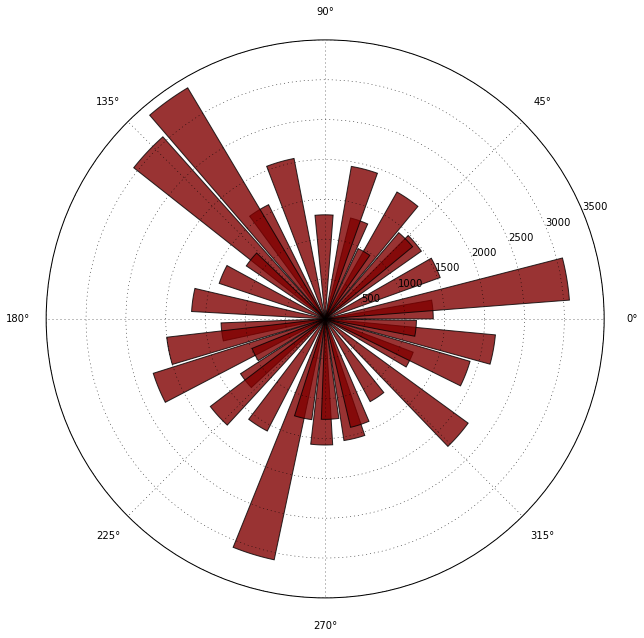

In [28]:
fig = plt.figure(figsize=(10, 12), dpi=100)
N = 36
hist, edges = np.histogram(degree_data, bins=N)
bottom = 8

theta = np.delete(edges,-1)
radii = hist
width = (2*np.pi) / N

ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# Use custom colors and opacity
for r, bar in zip(radii, bars):
    bar.set_facecolor(plt.cm.jet(r / 10.))
    bar.set_alpha(0.8)
plt.show()

Final Analysis  
It appears there are 3 dominate street angles at around 135o, 255o and 5o. Using this visualization as a guide, we could develop a measure of diagonality as defined by taking 1 minus the count of the 2 most dominate angle's and dividing that by the total count of the dataset. A perfectly non-diagonal city would result in a diagonality measure of (1-Count(dominant_angles))/(total_angles) = 0 where the 2 dominant angles are the only angles = total angles

In [40]:
dominant_angles = np.sum(heapq.nlargest(2, hist))
total_angles = np.sum(hist)
print "barcelona degree of diagonality =" + str(1-(float(dominant_angles)/float(total_angles)))

barcelona degree of diagonality =0.895038509762


Final Conclusions  
The "degree of diagonality" of Barcelona using the above measure is 0.895. I intuitivley guess this is a relatively (globally speaking) high degree of diagonality, but other cities could be run through the above methodology and compared. I had alot of fun with the above analysis, and can think of many further areas to continue developing and errors to fix, but I have a Nano Degree to finish!